In [ ]:
from Utilities import *
from torch import tensor
import torch
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
import time

class Timer():
    def __init__(self):
        self.time = 0
    def start(self,unit = 'ms'):
        self.time = 0
        self.unit = unit
        if unit == 'ns':
            self.time = time.perf_counter_ns()
            return
        elif unit == 'ms':
            self.time = time.perf_counter()
            return
    def stop(self):
        if self.unit == 'ns':
            self.time = time.perf_counter_ns() - self.time
        elif self.unit == 'ms':
            self.time = time.perf_counter() - self.time
        print(f'Time Elapsed {self.time/1000: .2f} {self.unit}')    
        return self.time
t = Timer()

# Test

In [ ]:
class basic(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.L = nn.Linear(1,1,bias = False)
        nn.init.constant_(self.L.weight,val = 1)
    def forward(self,x):
        x = self.L(x**2)
        return x

n = basic()
n(tensor([1.,2.],requires_grad=True).unsqueeze(dim = -1))

tensor([[1.],
        [4.]], grad_fn=<MmBackward0>)

In [ ]:
from functorch import vmap,vjp,jacrev,hessian, jacfwd,jvp
import timeit



def func(x):
    # return (x**2 +torch.ones_like(x)*x[0]**2 +torch.ones_like(x)*x[-1]**2)
    result = (x**2 *torch.ones_like(x)*x[0]**2*x[1]**2*x[-1]**2)
    # result = torch.ones_like(x)*torch.exp(x.sum())
    return result

# x = torch.rand((1000),requires_grad=True).unsqueeze(dim = 0)
x = tensor([1.,2.],requires_grad=True)


jacob = jacrev(func)
# print(func(x))
print(jacob(x))
print(hessian(func)(x).shape)


def aux_wrap(f):
    def aux_func(x):
        result = f(x)
        return result,result  
    return aux_func

#Crazy functional programming
def get_derivatives(net,x,hessian_vectors):
    aux_func = aux_wrap(net)

    jacob_func = (jacrev(aux_func,has_aux= True))

    out_jacob, partial_hess, out = vjp(jacob_func,x,has_aux=True)
    # print(out_jacob.shape)
    # print(hessian_vectors.shape)
    out_xx = vmap(lambda x : partial_hess(x,create_graph= True))(hessian_vectors)
    # return out,out_jacob,out_xx
    return out, out_jacob, out_xx


#Wrapper got get_derivatives to allow use of V map
def batch_get_derivatives_wrapper(net,hessian_vectors):
    def batched_derivatives(x):
        return get_derivatives(net,x,hessian_vectors)
    return batched_derivatives

def batched_deriv(net,x,hessian_vectors):
    ''' x is batched '''
    get_derivs = batch_get_derivatives_wrapper(net,hessian_vectors)
    return vmap(get_derivs)(x)

#JHessian = num,input, output , input size
# h_vec = torch.zeros((2,2))
# h_vec[0,0] = 1
# h_vec[1,1] = 1
# print(h_vec)


tensor([[ 64.,  32.],
        [128., 192.]], grad_fn=<ViewBackward0>)
torch.Size([2, 2, 2])


# Examples

In [ ]:
class MyNet(nn.Module):
    def __init__(self,n=30,l = 2) -> None:
        super().__init__()
        self.layer1 = nn.Linear(1,n,bias= False)
        self.non_lin = torch.tanh
        self.layers = nn.ModuleList([nn.Linear(n,n) for i in range(l)])
        self.fc = nn.Linear(n,1)
    def forward(self,x):
        out = self.layer1(x)

        for layer in self.layers:
            out = self.non_lin(layer(out))
        
        return self.fc(out)


# 1D sPRING


In [ ]:

# h_vec = torch.zeros((2,1,2))
# h_vec[0,0,0] = 1
# h_vec[1,0,1] = 1

h_vec = torch.ones((1,1,1))
# un_x = torch.linspace(-3,3, 100 ,requires_grad=True).unsqueeze(dim = -1)

x = torch.linspace(-3,3,100,requires_grad = True).unsqueeze(dim = -1)
y = torch.sin(x[0:10])

print(y)
print(x.shape)
net = MyNet()
net.non_lin = torch.tanh
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)
for ii in range(6000):
    optimizer.zero_grad()
    u,du,d2u = batched_deriv(net,x,h_vec)
    
    du = du.squeeze(dim=1)
    d2u = d2u[0].squeeze(dim=1)
    
    res = (u[0:10] - y).pow(2).mean() + 1e-1*(d2u +u).pow(2).mean()
    
    res.backward(retain_graph= True)
    
    
    optimizer.step()
    if (ii % 1000) == 0:
        # print(ut[0:10],end = '\r')
        print(f'Epoch {ii} Loss: {res}')
    

tensor([[-0.1411],
        [-0.2008],
        [-0.2598],
        [-0.3178],
        [-0.3746],
        [-0.4301],
        [-0.4840],
        [-0.5361],
        [-0.5863],
        [-0.6343]], grad_fn=<SinBackward0>)
torch.Size([100, 1])
Epoch 0 Loss: 0.1562800109386444
Epoch 1000 Loss: 0.02142675220966339
Epoch 2000 Loss: 0.009730275720357895
Epoch 3000 Loss: 0.002348999259993434
Epoch 4000 Loss: 0.0008229224476963282
Epoch 5000 Loss: 0.0004173512861598283


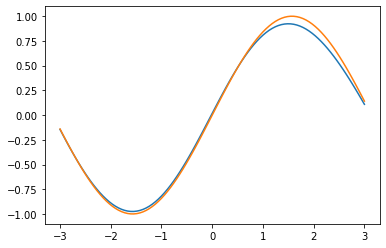

In [ ]:


x = torch.linspace(-3,3,100).unsqueeze(dim = -1)

u,du,d2u = batched_deriv(net,x,h_vec)

u,du,d2u = [i.detach() for i in [u,du,d2u[0]]]
plt.plot(x,u.squeeze(dim=-1))
plt.plot(x,torch.sin(x))

# hEAT


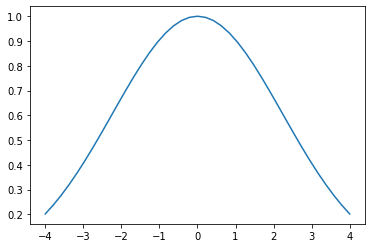

In [ ]:
x = torch.linspace(-4,4,39)
t = torch.linspace(0,1,10)

x_g,t_g = torch.meshgrid([x,t])

x_data = torch.flatten(x_g)
t_data = torch.flatten(t_g)

data = torch.stack( [x_data,t_data] ,dim = 1)

x_,t_ = 0,1
IC = data[data[:,t_] == 0]


y =  1*torch.exp(- 1/10*IC[:,x_]**2).unsqueeze(dim = -1)

plt.plot(x,y)


In [ ]:


h_vec = torch.zeros((2,1,2))
h_vec[0,0,0] = 1
h_vec[1,0,1] = 1

# h_vec = tensor([1]).squeeze(dim=0 )
# un_x = torch.linspace(-3,3, 100 ,requires_grad=True).unsqueeze(dim = -1)

x = data
IC_ = (data[:,t_] == 0)

BC_ = (data[:,x_] == -4) + (data[:,x_] == 4)

data.requires_grad =True
net = HFM_Net(2,1,10,20)
net.non_lin = torch.tanh
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)
for ii in range(10000):
    optimizer.zero_grad()
    u,du,d2u = batched_deriv(net,x,h_vec)
    
    du = du.squeeze(dim=1)
    d2u = d2u[0].squeeze(dim=1)
    
    uxx,ut = d2u[:,0,0],du[:,1]
    IC_res = (u[IC_]-y).pow(2).mean()
    # BC_res = (u[BC_] -5).pow(2).mean()
    PINN_loss = (uxx -ut).pow(2).sum()
    BC_res = 0
    res = IC_res + PINN_loss
    
    res.backward(retain_graph=True)
    
    
    optimizer.step()
    if (ii % 1000) == 0:
        # print(ut[0:10],end = '\r')
        print(f'Epoch {ii} Loss: {IC_res}\t {BC_res}\t {PINN_loss}')
    

Epoch 0 Loss: 0.5657498836517334	 0	 6.001755173201673e-05
Epoch 1000 Loss: 0.040583278983831406	 0	 0.0029693180695176125
Epoch 2000 Loss: 0.00039737147744745016	 0	 0.0008728475659154356
Epoch 3000 Loss: 0.0001538406650070101	 0	 0.0004890409763902426
Epoch 4000 Loss: 7.860940968384966e-05	 0	 0.0003599268093239516
Epoch 5000 Loss: 4.0773484215606004e-05	 0	 0.00021126540377736092
Epoch 6000 Loss: 2.250812940474134e-05	 0	 0.00014958999236114323
Epoch 7000 Loss: 1.2964384950464591e-05	 0	 0.00010857840970857069
Epoch 8000 Loss: 8.23372283775825e-06	 0	 8.717356104170904e-05
Epoch 9000 Loss: 5.932020485488465e-06	 0	 6.399460107786581e-05


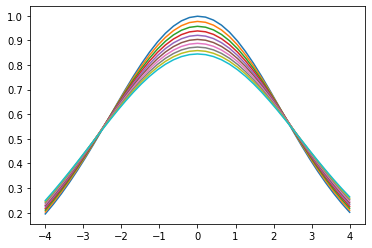

In [ ]:

xx = data

yy  = net(xx)
u,du,d2u = batched_deriv(net,xx,h_vec)
    
du = du.squeeze(dim=1)
d2u = d2u[0].squeeze(dim=1)

uxx,ut = d2u[:,0,0],du[:,1]
y =  1*torch.exp(- 1/10*xx[:,0]**2).unsqueeze(dim = -1)

xxx = xx[xx[:,1] == 0,0].detach()
# print(u[xx[:,1] == 0].shape)


for i in torch.linspace(0,1,10):
    plt.plot(xxx,u[xx[:,1] == i].detach())
# plt.plot(xxx,.detach())
# plt.plot(xxx,y.detach())

# plt.plot(xxx,y.detach())


# plt.plot(xxx,(uxx-ut).detach())


# Posieulle Flow Example (Low Reynolds Flow )

In [ ]:
x = torch.linspace(0,1,20)
y = torch.linspace(0,1,20)
t = torch.linspace(0,1,10)

grid = torch.meshgrid([x,y,t])

flat_grids = [torch.flatten(i) for i in grid]

data = torch.stack( flat_grids ,dim = 1)

x_,y_,t_ = 0,1,2

BC_ = torch.logical_or( (data[:,y_] == 0), (data[:,y_] == y[-1]))

IC_ = (data[:,x_] == 0)
# IC2_ = torch.logical_and( (data[:,x_] == 0),(data[:,t_] == t[2]))
# IC5_ = torch.logical_and( (data[:,x_] == 0),(data[:,t_] == t[5]))
data[IC_]


mu = 0.1
rho = 1
Re = rho/mu


y_s = data[data[:,x_] == 0][:,y_]
inlet = 1/(2*mu)*( y_s*(1-y_s))
# inlet = torch.ones_like(y)
inlet,data[IC_].shape,inlet.shape
# data[BC_]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2493, 0.2493, 0.2493, 0.2493, 0.2493, 0.2493, 0.2493, 0.2493,
         0.2493, 0.2493, 0.4709, 0.4709, 0.4709, 0.4709, 0.4709, 0.4709, 0.4709,
         0.4709, 0.4709, 0.4709, 0.6648, 0.6648, 0.6648, 0.6648, 0.6648, 0.6648,
         0.6648, 0.6648, 0.6648, 0.6648, 0.8310, 0.8310, 0.8310, 0.8310, 0.8310,
         0.8310, 0.8310, 0.8310, 0.8310, 0.8310, 0.9695, 0.9695, 0.9695, 0.9695,
         0.9695, 0.9695, 0.9695, 0.9695, 0.9695, 0.9695, 1.0803, 1.0803, 1.0803,
         1.0803, 1.0803, 1.0803, 1.0803, 1.0803, 1.0803, 1.0803, 1.1634, 1.1634,
         1.1634, 1.1634, 1.1634, 1.1634, 1.1634, 1.1634, 1.1634, 1.1634, 1.2188,
         1.2188, 1.2188, 1.2188, 1.2188, 1.2188, 1.2188, 1.2188, 1.2188, 1.2188,
         1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465,
         1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465, 1.2465,
         1.2465, 1.2465, 1.2

In [ ]:
h_vec =torch.stack([torch.zeros((3,3)) for i in range(4)])
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


#We want uxx, uyy, vxx, vyy
h_vec[0,0,0] = 1
h_vec[1,0,1] = 1
h_vec[2,1,0] = 1
h_vec[3,1,1] = 1 
h_vec = h_vec.to(device)
# h_vec = tensor([1]).squeeze(dim=0 )
# un_x = torch.linspace(-3,3, 100 ,requires_grad=True).unsqueeze(dim = -1)
print(device)
x = data
# x.requires_grad =True
x = x.to(device)
inlet= inlet.to(device)
IC_ = IC_.to(device)
BC_ = BC_.to(device)
net = HFM_Net(3,3,10,30)


net.non_lin = torch.tanh
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

for ii in range(7500):
    optimizer.zero_grad()
    out,out_jac,out_p_hess = batched_deriv(net,x,h_vec)
    out_p_hess = out_p_hess[0] 
    u,v,p = [out[:,i] for i in range(3)]
    
    
    u_jac = out_jac[:,0:2,0:2]
    dp = out_jac[:,2,0:2]
    ut = out_jac[:,0:2,-1]
    u_vec = out[:,0:2]

    uXX = out_p_hess[:,[0,1],[0,1]]
    u_xx = uXX[:,0]
    u_yy = uXX[:,1]


    vXX = out_p_hess[:,[2,3],[0,1]]
    v_xx = vXX[:,0]
    v_yy = vXX[:,1]

    # Lapl_vec = torch.stack([u_xx,v_xx],dim = -1)

    batched_Ax = vmap(torch.matmul)


    U = torch.stack([u,v],dim = -1)

    convection = batched_Ax(u_jac,U) 

    Lapl_vec = torch.stack([uXX.sum(dim = -1),vXX.sum(dim = -1)],dim = -1)

    ux = u_jac[:,0,0]
    vy = u_jac[:,1,1]

    #Equation Loss
    PINN_loss =( ( ut + convection  +dp -1/Re*Lapl_vec).pow(2).mean(dim = 0).sum()    ) 


 
    
    # PINN_loss =  1e-2 * (dp -1/Re*Lapl_vec).pow(2).mean()
    # PINN_loss = 1e-2*( -dp[:,0] -1/Re*(u_xx + u_yy) ).pow(2).mean()
    # print(PINN_loss.shape)
    # break
    
    
    

    in_comp_res = (ux+vy).pow(2).mean()

    IC_res = (u[IC_]-inlet).pow(2).mean() #+(u[IC2_]-inlet).pow(2).mean()+(u[IC5_]-inlet).pow(2).mean()
    
    P_res = (p[IC_]).pow(2).mean()
    # print(p[IC_].shape )
    # break
    BC_res = (u[BC_]).pow(2).mean() + (v[BC_]).pow(2).mean() 
    
    res = IC_res + BC_res +  PINN_loss +P_res + in_comp_res
    
    res.backward(retain_graph=True)
    
    optimizer.step()
    if (ii % 1000) == 0:
        # print(ut[0:10],end = '\r')
        print(f'Epoch {ii} Loss: {IC_res}\t {BC_res}\t {PINN_loss}')
print(f'Epoch {ii} Loss: {IC_res}\t {BC_res}\t {PINN_loss}')

cuda:0
Epoch 0 Loss: 1.3057342767715454	 0.08300848305225372	 1.1964927580265794e-05
Epoch 1000 Loss: 0.01247561164200306	 0.013988745398819447	 0.01327965222299099
Epoch 2000 Loss: 0.00778105529025197	 0.011183605529367924	 0.0018089493969455361
Epoch 3000 Loss: 0.006799043156206608	 0.010868077166378498	 0.0013758535496890545
Epoch 4000 Loss: 0.002710785251110792	 0.008391733281314373	 0.0019164166878908873
Epoch 5000 Loss: 0.00010602283145999536	 0.00020164545276202261	 0.0005566148902289569
Epoch 6000 Loss: 2.1862257199245505e-05	 3.192954682162963e-05	 0.0002042492269538343
Epoch 7000 Loss: 1.1099662515334785e-05	 1.2681173757300712e-05	 0.00010960359941236675
Epoch 7499 Loss: 9.176471394312102e-06	 9.106466677621938e-06	 8.674096898175776e-05


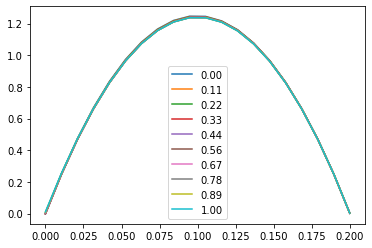

In [ ]:
x = torch.linspace(0,1,20)
y = torch.linspace(0,0.2,20)
t = torch.linspace(0,1,10)

out = net(data.cuda()).to('cpu')
u,v,p = [out[:,i] for i in range(3)]

u = u.detach()
v = v.detach()

for i in t:
    mask = torch.logical_and((data[:,t_] == i),(data[:,x_] == x[-1])  )
    plt.plot(y,u[mask],label = f'{float(i):.2f}')
    plt.legend()
    

# plt.plot(y,)

# Flow around a Cylinder


In [ ]:
x = torch.linspace(0,1,50)
y = torch.linspace(0,0.2,10)
t = torch.linspace(0,10,20)

grid = torch.meshgrid([x,y,t])

flat_grids = [torch.flatten(i) for i in grid]

data = torch.stack( flat_grids ,dim = 1)

x_,y_,t_ = 0,1,2


mu = 1
rho = 100
inlet = 1
Re = rho*inlet/mu

data.shape


torch.Size([10000, 3])

tensor([0.1800, 0.1821, 0.1842, 0.1863, 0.1884, 0.1905, 0.1926, 0.1947, 0.1968,
        0.1989, 0.2011, 0.2032, 0.2053, 0.2074, 0.2095, 0.2116, 0.2137, 0.2158,
        0.2179, 0.2200])
tensor([0.1001, 0.1089, 0.1123, 0.1146, 0.1163, 0.1176, 0.1186, 0.1193, 0.1197,
        0.1200, 0.1200, 0.1197, 0.1193, 0.1186, 0.1176, 0.1163, 0.1146, 0.1123,
        0.1089, 0.1001])
torch.Size([8000, 3])
tensor(True)


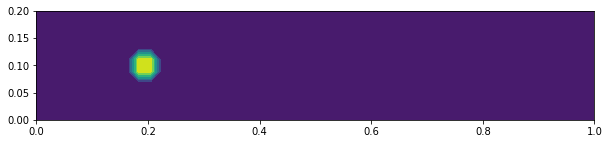

In [ ]:
x_co,y_co = 0.2,0.1


radius = 0.02
Cyl_BC = ((data[:,x_]-x_co)**2 + (data[:,y_]-y_co)**2) <= radius**2


Cyl_x = torch.linspace(x_co-(radius-1e-7),x_co+(radius-1e-7),20) 
Cyl_y =  y_co+torch.sqrt(radius**2-(Cyl_x-(x_co))**2)
print(Cyl_x)
print(Cyl_y)


Cyl_perim_grid = torch.meshgrid([Cyl_x,Cyl_y,t])
Cyl_flat_grid = [torch.flatten(i) for i in Cyl_perim_grid]

Cyl_perim_data = torch.stack( Cyl_flat_grid ,dim = 1)
print(Cyl_perim_data.shape )


contour_view = Cyl_BC.reshape(grid[0].shape)

print(torch.any( Cyl_BC))
plt.figure(figsize=(10,2))
plt.contourf(grid[0][:,:,0],grid[1][:,:,0],contour_view[:,:,0])

In [ ]:
data2 = torch.cat([data,Cyl_perim_data],dim = 0)
# data2 = data
Cyl_BC = ((data2[:,x_]-x_co)**2 + (data2[:,y_]-y_co)**2) <= (radius+1e-6)**2
BC = torch.logical_or( (data2[:,y_] == 0), (data2[:,y_] == y[-1]))
BC = torch.logical_or(BC,Cyl_BC)

main_data_len = data.shape[0]
# BC[main_data_len:] = True
# print(BC[main_data_len:].shape)


# IC_ = torch.logical_and( (data[:,x_] == 0),(data[:,t_] == 0))
IC =  (data2[:,x_] == 0) 



new_data = torch.empty((data2.shape[0],5))
new_data[:,0:3] = data2
new_data[:,3] = BC 
new_data[:,-1] = IC
new_data.shape,BC[main_data_len:]


(torch.Size([18000, 5]), tensor([True, True, True,  ..., True, True, True]))

tensor(True)


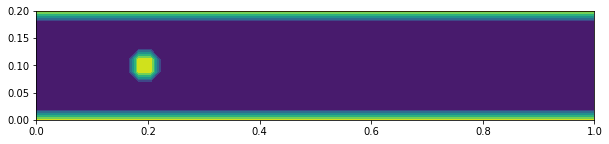

In [ ]:
contour_view = BC[:main_data_len].reshape(grid[0].shape)

print(torch.any( BC))
plt.figure(figsize=(10,2))
plt.contourf(grid[0][:,:,0],grid[1][:,:,0],contour_view[:,:,0])

In [ ]:
net = HFM_Net(3,3,15,30).cuda()

params = torch.load("Trained_.pth")

net.load_state_dict(params)

<All keys matched successfully>

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


h_vec =torch.stack([torch.zeros((3,3)) for i in range(4)])


#We want uxx, uyy, vxx, vyy
h_vec[0,0,0] = 1
h_vec[1,0,1] = 1
h_vec[2,1,0] = 1
h_vec[3,1,1] = 1 

h_vec = h_vec.to(device)
# h_vec = tensor([1]).squeeze(dim=0 )
# un_x = torch.linspace(-3,3, 100 ,requires_grad=True).unsqueeze(dim = -1)



# new_data.requires_grad =False
new_data = new_data.to(device)

train_loader = DataLoader(new_data,batch_size = 16000,shuffle = True)
# net = HFM_Net(3,3,15,30)
net.non_lin = torch.sin
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

net = net.to(device)

for ii in range(10000):
    running_loss = 0
    indi_loss = [0 for i in range(5)]
    for batch in train_loader:

        x = batch[:,0:3]
        BC_ = batch[:,3].to(dtype = torch.bool)
        IC_ = batch[:,4].to(dtype = torch.bool)


        optimizer.zero_grad()
        out,out_jac,out_p_hess = batched_deriv(net,x,h_vec)
        out_p_hess = out_p_hess[0] 
        u,v,p = [out[:,i] for i in range(3)]
        
        
        u_jac = out_jac[:,0:2,0:2]
        dp = out_jac[:,2,0:2]
        u_t = out_jac[:,0:2,-1]
        u_vec = out[:,0:2]

        uXX = out_p_hess[:,[0,1],[0,1]]
        u_xx = uXX[:,0]
        u_yy = uXX[:,1]
        
        
        vXX = out_p_hess[:,[2,3],[0,1]]
        v_xx = vXX[:,0]
        v_yy = vXX[:,1]
        
        # Lapl_vec = torch.stack([u_xx,v_xx],dim = -1)
        
        batched_Ax = vmap(torch.matmul)
        

        # U = torch.stack([u,v],dim = -1)
        
        # convection = batched_Ax(u_jac,U) 

        # Lapl_vec = torch.stack([uXX.sum(dim = -1),vXX.sum(dim = -1)],dim = -1)
        
        ux = u_jac[:,0,0]
        uy = u_jac[:,0,1]
        ut = u_t[:,0]

        vx = u_jac[:,1,0]
        vy = u_jac[:,1,1]
        vt = u_t[:,1]


        px = dp[:,0]
        py = dp[:,1]

        #Equation Loss
        

        e1 = ut + u*ux+v*uy + px - 1/Re*(u_xx + u_yy)
        e2 = vt + vx*u +vy*v + py - 1/Re*(v_xx+v_yy)

        PINN_loss = e1.pow(2).mean() + e2.pow(2).mean()
        # PINN_loss =( ( ut + convection  +dp -1/Re*Lapl_vec).pow(2).mean(dim = 0).sum()    ) 

        in_comp_res = ((ux+vy).pow(2).mean())

        
        # Initiatl Contition
        IC_res,P_res = 0,0
        if torch.any(IC_):
            IC_res = (u[IC_]-inlet).pow(2).mean()
            # P_res = (p[IC_]).pow(2).mean()
        
        #Boundary Condition
        BC_res =0
        if torch.any(BC_):
            BC_res = (u[BC_]).pow(2).mean() + (v[BC_]).pow(2).mean() 
        
            
        res =P_res+  IC_res + 1e2*BC_res +  1e-2*(PINN_loss + in_comp_res)
        
        res.backward(retain_graph=True)
        running_loss += res

        for i,loss in enumerate(map(float,[P_res , IC_res , BC_res ,  PINN_loss , in_comp_res])):
            indi_loss[i] += loss
        optimizer.step()
    if (ii % 100) == 0:
        losses = "\t".join(map(str,indi_loss))
        print(f'Epoch {ii} Loss: {losses}')
print(f'Epoch {ii} Loss: {IC_res}\t {BC_res}\t {PINN_loss}')
torch.save(net.state_dict(),f'Trained_{ii}.pth')

Epoch 0 Loss: 0.0	2.083383321762085	0.06589369452558458	3.123401464894414	1.6505083963274956
Epoch 100 Loss: 0.0	0.2498500943183899	0.0010441912745591253	0.6424338519573212	5.13577675819397
Epoch 200 Loss: 0.0	0.3781916946172714	0.0008055321231950074	0.3975217491388321	5.377727031707764
Epoch 300 Loss: 0.0	0.3269549012184143	0.0019360880833119154	0.3726454824209213	6.337337017059326
Epoch 400 Loss: 0.0	0.26877082884311676	0.0013846710789948702	0.40287119150161743	5.907771348953247
Epoch 500 Loss: 0.0	0.23677629977464676	0.0012079085572622716	0.360591858625412	5.789826154708862
Epoch 600 Loss: 0.0	0.23058681190013885	0.0006482226890511811	0.5493454337120056	5.525817394256592
Epoch 700 Loss: 0.0	0.26725177466869354	0.0010652247001416981	0.44717299938201904	5.62776255607605
Epoch 800 Loss: 0.0	0.2655005156993866	0.0014188314671628177	0.37780430912971497	5.427432060241699
Epoch 900 Loss: 0.0	0.24611616879701614	0.0013917679316364229	0.4223668575286865	6.312305450439453
Epoch 1000 Loss: 0.0

KeyboardInterrupt: ignored

In [ ]:
import os

os.getcwd()

'/content'

In [ ]:
torch.save(net.state_dict(),f'Trained_.pth')

In [ ]:
x = torch.linspace(0,1,50)
y = torch.linspace(0,0.2,10)
t = torch.linspace(0,10,20)
grid = torch.meshgrid([x,y,t])

flat_grids = [torch.flatten(i) for i in grid]

data = torch.stack( flat_grids ,dim = 1)


net_disp = net.to('cpu')

out = net_disp(data)

u,v,p = [out[:,i] for i in range(3)]

u.shape




torch.Size([10000])

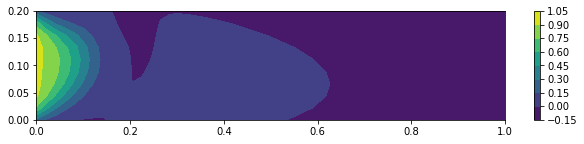

In [ ]:




u_grid = u.reshape(grid[0].shape).detach()

# cyl_out = u[25000:]


x_grid,y_grid = grid[0][:,:,0],grid[1][:,:,0]
import numpy as np
# plt.figure(figsize=(10,2))

fig,ax = plt.subplots()
fig.set_figwidth(10.5)
fig.set_figheight(2)
CS = ax.contourf(x_grid,y_grid,u_grid[:,:,-1] )
# circ = plt.Circle((1,0.5),0.1)
# ax.add_patch(circ)
fig.colorbar(CS)


# HFM

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import numpy as np
data = scipy.io.loadmat('/content/drive/MyDrive/HFM/Cylinder2D.mat')

t_star = data['t_star'] # T x 1
x_star = data['x_star'] # N x 1
y_star = data['y_star'] # N x 1

T = t_star.shape[0]
N = x_star.shape[0]

U_star = data['U_star'] # N x T
V_star = data['V_star'] # N x T
P_star = data['P_star'] # N x T
C_star = data['C_star'] # N x T

# Rearrange Data 
T_star = np.tile(t_star, (1,N)).T # N x T
X_star = np.tile(x_star, (1,T)) # N x T
Y_star = np.tile(y_star, (1,T)) # N x T

t = T_star.flatten()[:,None] # NT x 1
x = X_star.flatten()[:,None] # NT x 1
y = Y_star.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1
v = V_star.flatten()[:,None] # NT x 1
p = P_star.flatten()[:,None] # NT x 1
c = C_star.flatten()[:,None] # NT x 1

######################################################################
######################## Training Data ###############################
######################################################################

T_data = T # int(sys.argv[1])
N_data = N # int(sys.argv[2])
idx_t = np.concatenate([np.array([0]), np.random.choice(T-2, T_data-2, replace=False)+1, np.array([T-1])] )
idx_x = np.random.choice(N, N_data, replace=False)
t_data = T_star[:, idx_t][idx_x,:].flatten()[:,None]
x_data = X_star[:, idx_t][idx_x,:].flatten()[:,None]
y_data = Y_star[:, idx_t][idx_x,:].flatten()[:,None]
u_data = U_star[:, idx_t][idx_x,:].flatten()[:,None]
v_data = V_star[:, idx_t][idx_x,:].flatten()[:,None]
c_data = C_star[:, idx_t][idx_x,:].flatten()[:,None]
    
T_eqns = T
N_eqns = N
idx_t = np.concatenate([np.array([0]), np.random.choice(T-2, T_eqns-2, replace=False)+1, np.array([T-1])] )
idx_x = np.random.choice(N, N_eqns, replace=False)
t_eqns = T_star[:, idx_t][idx_x,:].flatten()[:,None]
x_eqns = X_star[:, idx_t][idx_x,:].flatten()[:,None]
y_eqns = Y_star[:, idx_t][idx_x,:].flatten()[:,None]

# Training Data on velocity (inlet)
t_inlet = t[x == x.min()][:,None]
x_inlet = x[x == x.min()][:,None]
y_inlet = y[x == x.min()][:,None]
u_inlet = u[x == x.min()][:,None]
v_inlet = v[x == x.min()][:,None]

data = np.stack([x_data,y_data,t_data,u_data,v_data], axis = 1)




In [ ]:

new_data = tensor(data,dtype = torch.float32).squeeze()
new_data = new_data[0:50000]
new_data.shape,new_data.dtype

(torch.Size([50000, 5]), torch.float32)

In [ ]:
net = HFM_Net(3,3,10,30)
Re = 100

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

h_vec =torch.stack([torch.zeros((3,3)) for i in range(4)])

h_vec[0,0,0] = 1
h_vec[1,0,1] = 1
h_vec[2,1,0] = 1
h_vec[3,1,1] = 1 

h_vec = h_vec.to(device)

new_data = new_data.to(device)

train_loader = DataLoader(new_data,batch_size = 50000,shuffle = False)
# net = HFM_Net(3,3,15,30)
net.non_lin = torch.sin
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

net = net.to(device)

for ii in range(10000):
    running_loss = 0
    indi_loss = [0 for i in range(5)]
    for batch in train_loader:

        xyt = batch[:,0:3]
        u_data = batch[:,3]
        v_data = batch[:,4]


        optimizer.zero_grad()
        out,out_jac,out_p_hess = batched_deriv(net,xyt,h_vec)
        out_p_hess = out_p_hess[0] 
        u,v,p = [out[:,i] for i in range(3)]
        
        
        u_jac = out_jac[:,0:2,0:2]
        dp = out_jac[:,2,0:2]
        u_t = out_jac[:,0:2,-1]
        u_vec = out[:,0:2]

        uXX = out_p_hess[:,[0,1],[0,1]]
        u_xx = uXX[:,0]
        u_yy = uXX[:,1]
        
        
        vXX = out_p_hess[:,[2,3],[0,1]]
        v_xx = vXX[:,0]
        v_yy = vXX[:,1]
        
        ux = u_jac[:,0,0]
        uy = u_jac[:,0,1]
        ut = u_t[:,0]

        vx = u_jac[:,1,0]
        vy = u_jac[:,1,1]
        vt = u_t[:,1]


        px = dp[:,0]
        py = dp[:,1]

        #Equation Loss
        

        e1 = ut + u*ux+v*uy + px - 1/Re*(u_xx + u_yy)
        e2 = vt + vx*u +vy*v + py - 1/Re*(v_xx+v_yy)

        PINN_loss = e1.pow(2).mean() + e2.pow(2).mean()
        # PINN_loss =( ( ut + convection  +dp -1/Re*Lapl_vec).pow(2).mean(dim = 0).sum()    ) 

        in_comp_res = ((ux+vy).pow(2).mean())

        
        # Initiatl Contition
        IC_res,P_res = 0,0
        
        num_points = 20000
        #Boundary Condition
        BC_res = (u[0:num_points]-u_data[0:num_points]).pow(2).mean() + (v[0:num_points]-v_data[0:num_points]).pow(2).mean() 

        res = BC_res +  1e-2*(PINN_loss + in_comp_res)
        
        res.backward(retain_graph=True)
        running_loss += res

        for i,loss in enumerate(map(float,[res, BC_res ,  PINN_loss , in_comp_res])):
            indi_loss[i] += loss
        optimizer.step()
    if (ii % 100) == 0:
        losses = "\t".join(map(str,indi_loss))
        print(f'Epoch {ii} Loss: {losses}')
print(f'Epoch {ii} Loss: {IC_res}\t {BC_res}\t {PINN_loss}')
torch.save(net.state_dict(),f'Trained_{ii}.pth')

Epoch 0 Loss: 0.022726578637957573	0.02140018902719021	0.06215599179267883	0.07048296928405762	0
Epoch 100 Loss: 0.01425222959369421	0.012984700500965118	0.05358143150806427	0.07317151874303818	0
Epoch 200 Loss: 0.01294576283544302	0.011743440292775631	0.0514591783285141	0.0687730461359024	0
Epoch 300 Loss: 0.012082425877451897	0.0109098507091403	0.05114535242319107	0.06611213088035583	0
Epoch 400 Loss: 0.011428548023104668	0.010274780914187431	0.051089171320199966	0.06428749114274979	0
Epoch 500 Loss: 0.011069083586335182	0.00997253693640232	0.04998471587896347	0.059669967740774155	0
Epoch 600 Loss: 0.0104525750502944	0.009338639676570892	0.05014888942241669	0.06124468147754669	0
Epoch 700 Loss: 0.010071663185954094	0.008996428921818733	0.04911758005619049	0.05840582400560379	0
Epoch 800 Loss: 0.009670662693679333	0.008598711341619492	0.04883240908384323	0.05836270749568939	0
Epoch 900 Loss: 0.00931236520409584	0.008267585188150406	0.048126209527254105	0.05635179579257965	0
Epoch 1000

KeyboardInterrupt: ignored

In [ ]:
torch.save(net.state_dict(),'/content/drive/MyDrive/HFM/HFM_Test.pth')

In [ ]:
x = torch.linspace(-2.5,7.5,100)
y = torch.linspace(-2.5,2.5,100)
t = torch.linspace(0,10,20)
grid = torch.meshgrid([x,y,t])

flat_grids = [torch.flatten(i) for i in grid]

data_val = torch.stack( flat_grids ,dim = 1)


net_disp = net.to('cpu')

out = net_disp(data_val)

u,v,p = [out[:,i] for i in range(3)]

u.shape

torch.Size([200000])

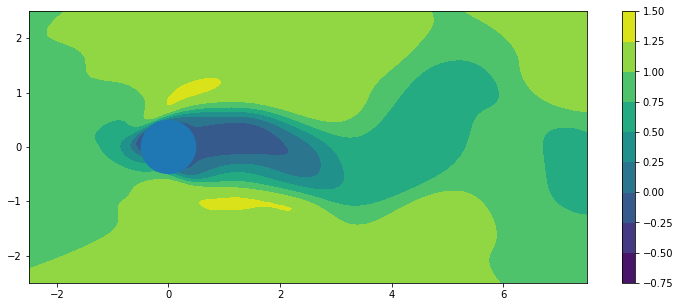

In [ ]:


u_grid = u.reshape(grid[0].shape).detach()

x_grid,y_grid = grid[0][:,:,0],grid[1][:,:,0]
import numpy as np
# plt.figure(figsize=(10,2))

fig,ax = plt.subplots()
fig.set_figwidth(12.5)
fig.set_figheight(5)
CS = ax.contourf(x_grid,y_grid,u_grid[:,:,10] )
circ = plt.Circle((0,0),0.5)
ax.add_patch(circ)
fig.colorbar(CS)